### Experiment 2 - Simulated mutated references, simulate raw data, align raw data to mutated references

This notebook is modified from the original experiment-2 version to deal with proteins!

In [59]:
from Bio import SeqIO
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [60]:
# read the original NCBI reference sequence

filename = "../refs/rhinovirus_YP_001552411.fasta" 
#filename = "../refs/streptococcus_VDG79570_102aa.fasta"
#filename = "../refs/streptococcus_VDG79582_PBP_731aa.fasta"
#filename = "../refs/streptococcus_VDG79577_shortened_50aa.fasta"

original_record = SeqIO.read(filename, "fasta") # NOTE: this only works with single-sequence .fasta files

#id_thresholds = [0.99, 0.97, 0.95, 0.92, 0.9, 0.85, 0.8]  # specified list of thresholds
id_thresholds = [0.9, 0.8, 0.7, 0.6, 0.5]

def mutate_sequence(sequence, pid):
    '''
    Given a sequence and a % ID threshold, mutate the sequence at random positions to produce
    a new sequence with the specified % ID. Return the new sequence string.
    '''
    
    swap_values = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 
                             'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'] # amino acid characters
    
    len_of_seq = len(sequence)
    num_bp_to_change = (np.round(len_of_seq) * (1-pid))
    all_bp_locs = [b for b in range(len_of_seq)]    
    bp_locs_to_change = random.sample(all_bp_locs, int(num_bp_to_change))
    
    # loop through indices of bases to change and swap out values
    new_seq = list(sequence)
    for bp in bp_locs_to_change:
        new_seq[bp] = random.sample([i for i in swap_values if i != new_seq[bp] ], 1)[0]
        
    return("".join(new_seq))

# currate a dictionary of mutated sequences at specified %ID thresholds
sequence_dict = {original_record.id : original_record.seq}
for i in id_thresholds:
    for j in range(1):
        this_seq = mutate_sequence(original_record.seq, i)
        #this_seq_rt = protein_to_dna(this_seq)
        sequence_dict[str(i) + '-' + str(j+1)] = this_seq#_rt
        
# write the mutated sequences to a fasta file
for s in sequence_dict:
    with open( s + ".ref.fasta", 'w') as f: 
        f.write('>' + s + '\n' + str(sequence_dict[s]) + '\n')
    f.close()
    
#NOTE: verified that this is working correctly by running BLASTx on the resulting *.ref.fasta sequences
#      the BLASTx results for the NT sequence showed that the NT sequence listed as 99% has 99% similarity, 
#      the NT seq for 97% has 97% protein similarity...etc

In [61]:
def protein_to_dna(protein_sequence):
    '''
    Given a protein sequence, reverse translate the sequence to produce a nucleotide sequence
    '''
    # Dictionary mapping amino acids to DNA codons
    codon_table = {
        'A': ['GCT', 'GCC', 'GCA', 'GCG'],
        'C': ['TGT', 'TGC'],
        'D': ['GAT', 'GAC'],
        'E': ['GAA', 'GAG'],
        'F': ['TTT', 'TTC'],
        'G': ['GGT', 'GGC', 'GGA', 'GGG'],
        'H': ['CAT', 'CAC'],
        'I': ['ATT', 'ATC', 'ATA'],
        'K': ['AAA', 'AAG'],
        'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'],
        'M': ['ATG'],
        'N': ['AAT', 'AAC'],
        'P': ['CCT', 'CCC', 'CCA', 'CCG'],
        'Q': ['CAA', 'CAG'],
        'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],
        'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'],
        'T': ['ACT', 'ACC', 'ACA', 'ACG'],
        'V': ['GTT', 'GTC', 'GTA', 'GTG'],
        'W': ['TGG'],
        'Y': ['TAT', 'TAC'],
        '*': ['TAA', 'TAG', 'TGA']  # Stop codons
    }
    
    dna_sequence = ''
    
    # Convert each amino acid to the corresponding DNA codon
    for amino_acid in protein_sequence:
        codons = codon_table.get(amino_acid, [])
        if len(codons) == 0:
            raise ValueError(f"Invalid amino acid: {amino_acid}")
        
        # Choose a random codon for the amino acid
        codon = codons[0]  # Change this if you want a random codon
        
        dna_sequence += codon
    
    return dna_sequence


# write a nucleotide sequence version of the original input to file for use in data simulation step
nt_filename = '.'.join(filename.split('/')[-1].split('.')[0:-1])  + '.ntseq.fasta'
with open(nt_filename, 'w') as f:
    f.write('>' + original_record.id + '_ntseq' + '\n')
    f.write(protein_to_dna(original_record.seq))
f.close()

In [62]:
# simulate sequences from the input file
! iss generate --genomes {nt_filename} --model miseq --output miseq_reads --n_reads 100000
! cat miseq_reads_R1.fastq miseq_reads_R2.fastq > miseq_reads_R1R2.fastq

INFO:iss.app:Starting iss generate
INFO:iss.app:Using kde ErrorModel
INFO:iss.util:Stitching input files together
INFO:iss.app:Using lognormal abundance distribution
INFO:iss.app:Using 2 cpus for read generation
INFO:iss.app:Generating 100000 reads
INFO:iss.app:Generating reads for record: YP_001552411.1_ntseq
INFO:iss.util:Stitching input files together
INFO:iss.util:Stitching input files together
INFO:iss.util:Cleaning up
INFO:iss.app:Read generation complete


In [63]:
# run minimap2

result_dictionary = {}

for i in sequence_dict:
    this_ref = str(i) + ".ref.fasta"

    # note: this is the minimap2 command used in CZ ID short-read-mngs workflow
    ! diamond makedb --in {this_ref} -d reference
    
    # note: there was an error when I was running with PE reads separately, 
    #       "Unequal number of sequences in paired read files" -- so I concatenate them above and run 
    #       the combined file through DIAMOND
    ! diamond blastx -d reference -q miseq_reads_R1R2.fastq --mid-sensitive --outfmt 101 -o aln.sam
    unmapped_reads_string = !grep -v ^@ aln.sam| cut -f3 | grep "\*" | wc -l
    unmapped_reads_count = int(unmapped_reads_string[0].strip())
    
    result_dictionary[i] = unmapped_reads_count

diamond v2.1.6.160 (C) Max Planck Society for the Advancement of Science
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 16
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Database input file: YP_001552411.1.ref.fasta
Opening the database file...  [0s]
Loading sequences...  [0s]
Masking sequences...  [0s]
Writing sequences...  [0s]
Hashing sequences...  [0s]
Loading sequences...  [0s]
Writing trailer...  [0s]
Closing the input file...  [0s]
Closing the database file...  [0s]

Database sequences  1
  Database letters  2144
     Database hash  1568251507773c3818ed9cfa62138999
        Total time  0.001000s
diamond v2.1.6.160 (C) Max Planck Society for the Advancement of Science
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU thr

Building query seed array...  [0.096s]
Computing hash join...  [0.034s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0.08s]
Deallocating memory...  [0s]
Processing query block 1, reference block 1/1, shape 6/8, index chunk 4/4.
Building reference seed array...  [0.002s]
Building query seed array...  [0.078s]
Computing hash join...  [0.025s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0.08s]
Deallocating memory...  [0s]
Processing query block 1, reference block 1/1, shape 7/8, index chunk 1/4.
Building reference seed array...  [0s]
Building query seed array...  [0.076s]
Computing hash join...  [0.011s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0.101s]
Deallocating memory...  [0.001s]
Processing query block 1, reference block 1/1, shape 7/8, index chunk 2/4.
Building reference seed array...  [0.002s]
Building query seed array...  [0.085s]
Computing hash join...  [0.026s]
Masking low complexity seeds...  [0s]
Searching alignment

Searching alignments...  [0.035s]
Deallocating memory...  [0.001s]
Processing query block 1, reference block 1/1, shape 3/8, index chunk 4/4.
Building reference seed array...  [0s]
Building query seed array...  [0.077s]
Computing hash join...  [0.017s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0.037s]
Deallocating memory...  [0s]
Processing query block 1, reference block 1/1, shape 4/8, index chunk 1/4.
Building reference seed array...  [0s]
Building query seed array...  [0.077s]
Computing hash join...  [0.016s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0.042s]
Deallocating memory...  [0.002s]
Processing query block 1, reference block 1/1, shape 4/8, index chunk 2/4.
Building reference seed array...  [0s]
Building query seed array...  [0.078s]
Computing hash join...  [0.023s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0.035s]
Deallocating memory...  [0.001s]
Processing query block 1, reference block 1/1, shape 4/8, index 

Loading query sequences...  [0.42s]
Masking queries...  [69.478s]
Algorithm: Double-indexed
Building query histograms...  [0.273s]
Seeking in database...  [0s]
Loading reference sequences...  [0s]
Masking reference...  [0.001s]
Initializing temporary storage...  [0.006s]
Building reference histograms...  [0.001s]
Allocating buffers...  [0s]
Processing query block 1, reference block 1/1, shape 1/8, index chunk 1/4.
Building reference seed array...  [0.001s]
Building query seed array...  [0.077s]
Computing hash join...  [0.008s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0.017s]
Deallocating memory...  [0s]
Processing query block 1, reference block 1/1, shape 1/8, index chunk 2/4.
Building reference seed array...  [0.001s]
Building query seed array...  [0.079s]
Computing hash join...  [0.007s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0.019s]
Deallocating memory...  [0.001s]
Processing query block 1, reference block 1/1, shape 1/8, index chunk 3

Building query seed array...  [0.076s]
Computing hash join...  [0.012s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0.017s]
Deallocating memory...  [0.001s]
Processing query block 1, reference block 1/1, shape 8/8, index chunk 1/4.
Building reference seed array...  [0.001s]
Building query seed array...  [0.078s]
Computing hash join...  [0.017s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0.015s]
Deallocating memory...  [0s]
Processing query block 1, reference block 1/1, shape 8/8, index chunk 2/4.
Building reference seed array...  [0.001s]
Building query seed array...  [0.078s]
Computing hash join...  [0.017s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0.015s]
Deallocating memory...  [0s]
Processing query block 1, reference block 1/1, shape 8/8, index chunk 3/4.
Building reference seed array...  [0.001s]
Building query seed array...  [0.078s]
Computing hash join...  [0.013s]
Masking low complexity seeds...  [0s]
Searching ali

Building query seed array...  [0.078s]
Computing hash join...  [0.024s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0.007s]
Deallocating memory...  [0s]
Processing query block 1, reference block 1/1, shape 5/8, index chunk 2/4.
Building reference seed array...  [0s]
Building query seed array...  [0.08s]
Computing hash join...  [0.008s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0.006s]
Deallocating memory...  [0s]
Processing query block 1, reference block 1/1, shape 5/8, index chunk 3/4.
Building reference seed array...  [0.001s]
Building query seed array...  [0.081s]
Computing hash join...  [0.018s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0.007s]
Deallocating memory...  [0s]
Processing query block 1, reference block 1/1, shape 5/8, index chunk 4/4.
Building reference seed array...  [0.001s]
Building query seed array...  [0.08s]
Computing hash join...  [0.021s]
Masking low complexity seeds...  [0s]
Searching alignments...

Computing hash join...  [0.008s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0.004s]
Deallocating memory...  [0s]
Processing query block 1, reference block 1/1, shape 2/8, index chunk 2/4.
Building reference seed array...  [0.001s]
Building query seed array...  [0.08s]
Computing hash join...  [0.009s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0.004s]
Deallocating memory...  [0s]
Processing query block 1, reference block 1/1, shape 2/8, index chunk 3/4.
Building reference seed array...  [0.001s]
Building query seed array...  [0.084s]
Computing hash join...  [0.007s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0.003s]
Deallocating memory...  [0s]
Processing query block 1, reference block 1/1, shape 2/8, index chunk 4/4.
Building reference seed array...  [0.001s]
Building query seed array...  [0.078s]
Computing hash join...  [0.021s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0.003s]
Deallocating memory... 

Loading query sequences...  [0s]
Closing the input file...  [0s]
Closing the output file...  [0.008s]
Closing the database...  [0s]
Cleaning up...  [0s]
Total time = 81.454s
Reported 91478 pairwise alignments, 91478 HSPs.
91478 queries aligned.
diamond v2.1.6.160 (C) Max Planck Society for the Advancement of Science
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 16
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Database input file: 0.5-1.ref.fasta
Opening the database file...  [0.01s]
Loading sequences...  [0s]
Masking sequences...  [0s]
Writing sequences...  [0s]
Hashing sequences...  [0s]
Loading sequences...  [0s]
Writing trailer...  [0s]
Closing the input file...  [0s]
Closing the database file...  [0s]

Database sequences  1
  Database letters  2144
     Database hash  dba859faa46f2e284f03b6c3a02bf698
        Total time  0.011000s


Building query seed array...  [0.077s]
Computing hash join...  [0.013s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0.001s]
Deallocating memory...  [0s]
Processing query block 1, reference block 1/1, shape 6/8, index chunk 4/4.
Building reference seed array...  [0.001s]
Building query seed array...  [0.076s]
Computing hash join...  [0.01s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0.003s]
Deallocating memory...  [0s]
Processing query block 1, reference block 1/1, shape 7/8, index chunk 1/4.
Building reference seed array...  [0.001s]
Building query seed array...  [0.075s]
Computing hash join...  [0.021s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0.001s]
Deallocating memory...  [0s]
Processing query block 1, reference block 1/1, shape 7/8, index chunk 2/4.
Building reference seed array...  [0s]
Building query seed array...  [0.077s]
Computing hash join...  [0.02s]
Masking low complexity seeds...  [0s]
Searching alignments...

YP_001552411.1       49
0.9-1                49
0.8-1                57
0.7-1               114
0.6-1              8522
0.5-1             47263
dtype: int64
YP_001552411.1    0.00049
0.9-1             0.00049
0.8-1             0.00057
0.7-1             0.00114
0.6-1             0.08522
0.5-1             0.47263
dtype: float64


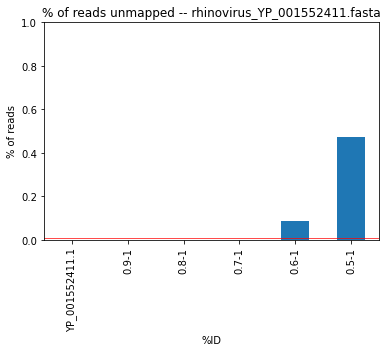

In [64]:
ser = pd.Series(result_dictionary)
print(ser)
print(ser/100000)

graph = (ser/100000).plot(kind='bar', title='% of reads unmapped -- ' + filename.split('/')[-1], 
                          ylabel = "% of reads", xlabel = "%ID",
                         ylim = (0,1))
graph.axhline(0.01, lw=.7, color='red')
plt.show()